# **NLP Tweet Disaster Predictions**
## Individual Assignment
---


Nora Patricia Carcamo Acosta

4/19/2020

This challenge propose a binary text classification task: we have to decide whether a tweet is talking about an actual disaster or not. 

This is a comprehensive programming solution which includes a analysis of the data, the hypothesis to use/implement, a detailed explanation of each step, and the analysis of the results. The final model section includes conclusions, final recommendation, and ideas to further improve the solution as a future work.

The written report with a summary of the findings of this analysis is available at the following link: https://70176fb8-5536-4e31-a86f-83a35c7bceda.filesusr.com/ugd/d99df2_4bc351ab2d244fc58984978281d7cfd1.pdf

## Kaggle Competition Description

Competition Description
Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. If this is your first time working on an NLP problem, we've created a quick tutorial to get you up and running.

Acknowledgments
This dataset was created by the company figure-eight and originally shared on their ‘Data For Everyone’ website.

Tweet source: https://twitter.com/AnyOtherAnnaK/status/629195955506708480

Reference material from:
Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

BERT tutorial:
https://github.com/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb

### Install Required Libraries

Since this is a google colab notebook, the data files are located in my google drive account. To access, click the link and paste the authorization code. 

In [3]:
! pip install bert-tensorflow
! pip install tensorflow==1.15 

     |████████████████████████████████| 71kB 5.1MB/s 
     |████████████████████████████████| 412.3MB 42kB/s 
     |████████████████████████████████| 3.8MB 48.3MB/s 
     |████████████████████████████████| 512kB 50.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=3651b4a5cdb997bb5ca108d2361c374f57b5496e4484962a31f8e8fe892c8dd8
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorflow 2.2.0rc2
    Uninstalling tensorflow-2.2.0

In [50]:
# import necessary libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re 
import string
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime

nltk.download('punkt')
nltk.download('stopwords')
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
sno= nltk.stem.SnowballStemmer('english')
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from nltk.classify import MaxentClassifier
from sklearn.model_selection import train_test_split, cross_val_score
stopwords = set(stopwords.words('english'))
#from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn.metrics import classification_report

import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

from tensorflow import keras
import os
import re

from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Data Import

In [0]:
# assign training and test data
train_df = pd.read_csv('drive/My Drive/Colab Notebooks/NLP_IndividualAssignment/train.csv')
test_df = pd.read_csv('drive/My Drive/Colab Notebooks/NLP_IndividualAssignment/test.csv')

In [6]:
print('Train Set Shape = {}'.format(train_df.shape))
print('Test Set Shape = {}'.format(test_df.shape))

Train Set Shape = (7613, 5)
Test Set Shape = (3263, 4)


In [7]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Data Analysis
The following data analysis will give us a deeper understanding of the text classified as disaster and the text classified as not disaster as it is important to understand the data provided before building any model. 

### Missing Values

In [8]:
# There check for NaN values in our datasets
print('The training set contains NaN values: ' , train_df.isna().any().any())
print('The test set contains NaN values :', test_df.isna().any().any())

The training set contains NaN values:  True
The test set contains NaN values : True


Both training and test sets contain approximately the same percentage of missing values in the features location and keyword. The values in the training set will be imputed with nokey and nolocation. 

In [9]:
# What percentage of values are NaN in features keyword and location
print("Percentage of missing values in training set")
print(train_df.isna().sum()/float(len(train_df))*100)

print("Percentage of missing values in test set")
print(test_df.isna().sum()/float(len(test_df))*100)

Percentage of missing values in training set
id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64
Percentage of missing values in test set
id           0.000000
keyword      0.796813
location    33.864542
text         0.000000
dtype: float64


In [10]:
for df in [train_df, test_df]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no{col}')

print('Missing values in training set: ', train_df.isna().sum().sum()) 
print('Missing values in test set: ', test_df.isna().sum().sum())

Missing values in training set:  0
Missing values in test set:  0


#### Location
The feature location has approximately 33% of missing values. In the training set, this represents 2,533 observations. However, the bigger problem with this feature is that it has 3,342 unique values many of which can't be put on a map such as ***'å_: ?? ÌÑ ? : ?, Tips on my blog at'*** shown below making it difficult to gain value from this information. This feature will not be used on the analysis.  

In [11]:
train_df['location'].value_counts()

nolocation                  2533
USA                          104
New York                      71
United States                 50
London                        45
                            ... 
Pioneer Village, KY            1
Okuma Town, Fukushima          1
City of London, London         1
@UntmdOutdoors #T.O.R.K        1
Canada                         1
Name: location, Length: 3342, dtype: int64

In [12]:
len(train_df['location'].unique())

3342

### Class Analysis
Let's look at a sample of 10 tweets classified as class 0 (not disaster) and class 1 (disaster) to get an idea of what these look like. 

In [13]:
# Samples of tweets labeled 0, not disaster tweet
train_df[train_df["target"] == 0]["text"].values[:10]

array(["What's up man?", 'I love fruits', 'Summer is lovely',
       'My car is so fast', 'What a goooooooaaaaaal!!!!!!',
       'this is ridiculous....', 'London is cool ;)', 'Love skiing',
       'What a wonderful day!', 'LOOOOOOL'], dtype=object)

In [14]:
# Samples of tweets labeled 1, disaster tweet
train_df[train_df["target"] == 1]["text"].values[:10]

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       '13,000 people receive #wildfires evacuation orders in California ',
       'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ',
       '#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires',
       '#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas',
       "I'm on top of the hill and I can see a fire in the woods...",
       "There's an emergency evacuation happening now in the building across the street",
       "I'm afraid that the tornado is coming to our area..."],
      dtype=object)

The target class represents 43% of the training set, so I will consider it to be balanced. 

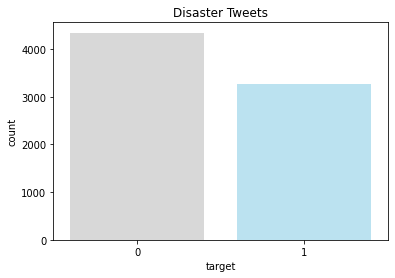

In [15]:
#plot histogram of target variable
sns.countplot(x=train_df['target'], palette=['grey','#00ACEE'], alpha = 0.3)
plt.title('Disaster Tweets')
plt.show()

In [16]:
len(train_df[train_df['target']==1])

3271

In [17]:
len(train_df[train_df['target']==1])/len(train_df)*100

42.96597924602653

## Feature Generation

The rich text provided in the tweets is a great source of information to generate the following additional features: tweet length, word count, hashtag count, punctuation count. I will analyze what these features mean for our classes.  

Text(0.5, 1.0, 'Tweet Word Count')

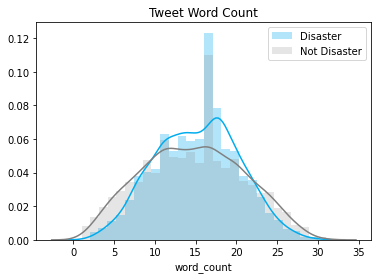

In [18]:
# Word Count
train_df['word_count'] = train_df['text'].str.split().map(lambda x: len(x))

sns.distplot(train_df[train_df['target']==1]['word_count'], color = '#00ACEE', hist_kws={'alpha':0.30}, label="Disaster")
sns.distplot(train_df[train_df['target']==0]['word_count'], color = 'Gray', hist_kws={'alpha':0.20}, label="Not Disaster")
plt.legend()
plt.title('Tweet Word Count')

Text(0.5, 1.0, 'Tweet Character Length')

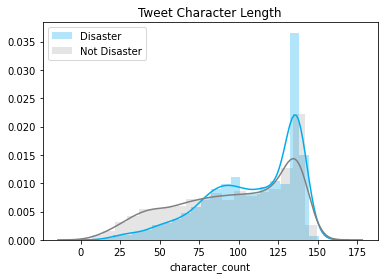

In [19]:
# Character Count
train_df['character_count'] = train_df['text'].astype(str).apply(len)

sns.distplot(train_df[train_df['target']==1]['character_count'], color = '#00ACEE', hist_kws={'alpha':0.30}, label="Disaster")
sns.distplot(train_df[train_df['target']==0]['character_count'], color = 'Gray', hist_kws={'alpha':0.20}, label="Not Disaster")
plt.legend()
plt.title('Tweet Character Length')

Text(0.5, 1.0, 'Tweet Hashtag Count')

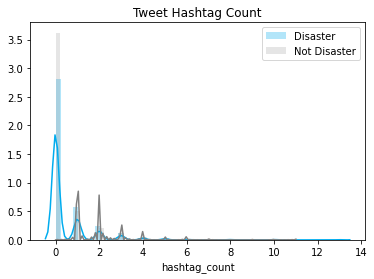

In [20]:
train_df['hashtag_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

sns.distplot(train_df[train_df['target']==1]['hashtag_count'], color = '#00ACEE', hist_kws={'alpha':0.30}, label="Disaster")
sns.distplot(train_df[train_df['target']==0]['hashtag_count'], color = 'Gray', hist_kws={'alpha':0.20}, label="Not Disaster")
plt.legend()
plt.title('Tweet Hashtag Count')

Text(0.5, 1.0, 'Tweet Punctuation Count')

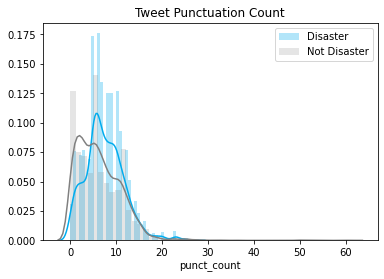

In [21]:
train_df['punct_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

sns.distplot(train_df[train_df['target']==1]['punct_count'], color = '#00ACEE', hist_kws={'alpha':0.30}, label="Disaster")
sns.distplot(train_df[train_df['target']==0]['punct_count'], color = 'Gray', hist_kws={'alpha':0.20}, label="Not Disaster")
plt.legend()
plt.title('Tweet Punctuation Count')

## *Tokenizer*

Let's look at a sample tweet to understand the format and them apply transformations to clean and extract meaning from it. Tweet number 7,610 contains brackets, numbers, punctuation, and a hyperlink. I will use Tweet Tokenizer from NLTK to tokenize the text. 

In [40]:
train_df['text'][1]

'Forest fire near La Ronge Sask. Canada'

In [0]:
train_df['tokens'] = train_df['text'].apply(lambda x: word_tokenize(x))

In [39]:
train_df['tokens'][1]

['Forest', 'fire', 'near', 'La', 'Ronge', 'Sask', '.', 'Canada']

### Simple Statistics - Frequency Distribution

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


FrequencyVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f490d900cf8>,
                    color=None,
                    features=['00', '000', '0000', '007npen6lg', '00cy9vxeff',
                              '00end', '00pm', '01', '02', '0215', '02elqlopfk',
                              '02pm', '03', '030', '033', '034', '039',
                              '03l7nwqdje', '04', '05', '05th', '06', '060',
                              '061', '06jst', '07', '073izwx0lb', '08',
                              '0840728', '0853', ...],
                    n=None, orient='v')

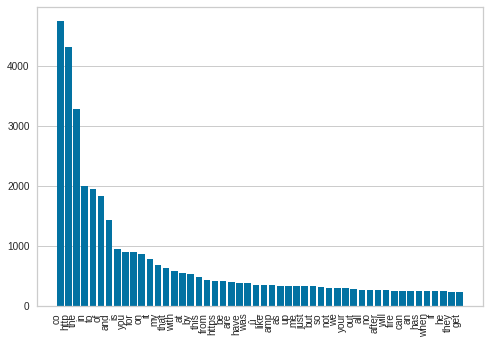

In [53]:
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(train_df['text'])
features   = vectorizer.get_feature_names()

visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer

# Data Preparation

## Data Cleaning
When looking at sample tweet number 7,610 we can see special characters like brackets, punctuation, numbers and hyperlinks.

In [54]:
train_df['text'][7610]

'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ'

It's important to clean up the text before moving forward with data modeling. For this process, I will remove html, punctuation, hashtags, non-alpha characters, text will be set in lowercase and words will be stemmed with a snowball stemmer. 

In [55]:
# remove html
def cleanhtml (sentence):
    cleantext = re.sub(r'http\S+',r'',sentence)
    return cleantext

# remove punctuation
def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|)|\|/]',r' ',cleaned)      
    return cleaned

# function for cleaning 'column' of dataframe 'data' and saving cleaned text in column 'clean_txt'
def cleantxt(data,column):
    str1=' '
    final_string=[]
    s=''
    for sent in data[column]:
        filter_sent = []
        rem_html = cleanhtml(sent)
        rem_punc = cleanpunc (rem_html)
        for w in rem_punc.split():
            if ((w.isalpha()) & (len(w)>2)):
                if (w.lower() not in stopwords):
                    s=(sno.stem(w.lower())).encode('utf8')
                    filter_sent.append(s)
                else:
                    continue
            else:
                continue
        str1 = b" ".join(filter_sent)
        final_string.append(str1)
    data['clean_txt'] = np.array(final_string)

cleantxt(train_df,'text')

print(train_df.columns)

Index(['id', 'keyword', 'location', 'text', 'target', 'word_count',
       'character_count', 'hashtag_count', 'punct_count', 'tokens',
       'clean_txt'],
      dtype='object')


In [56]:
# Sample of tweets before cleaning
train_df['text'][:10]

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
5    #RockyFire Update => California Hwy. 20 closed...
6    #flood #disaster Heavy rain causes flash flood...
7    I'm on top of the hill and I can see a fire in...
8    There's an emergency evacuation happening now ...
9    I'm afraid that the tornado is coming to our a...
Name: text, dtype: object

In [57]:
# Sample of tweets after cleaning
train_df['clean_txt'][:10]

0            b'deed reason earthquak may allah forgiv'
1                 b'forest fire near rong sask canada'
2    b'resid ask shelter place notifi offic evacu s...
3       b'peopl receiv wildfir evacu order california'
4    b'got sent photo rubi alaska smoke wildfir pou...
5    b'rockyfir updat california hwi close direct d...
6    b'flood disast heavi rain caus flash flood str...
7                            b'top hill see fire wood'
8      b'there emerg evacu happen build across street'
9                          b'afraid tornado come area'
Name: clean_txt, dtype: bytes1024

## TFIDF Matrix
TF-IDF is a common term weighting scheme in information retrieval used in text classification. It represents the term-frequency times the inverse document-frequency. Using TF-IDF scales down the impact of low frequency tokens. The vectorizer extracts unigrams, bigrams and 3-grams for analysis from the clean_text as input, and outputs a sparse matrix which is tf-idf-weighted which will be used to test the following algorithms for text classification.

In [58]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,3)) # one,two and three gram vectorization
tfidf_mat = tfidf_vect.fit_transform(train_df['clean_txt'].values) # fit_transform vectorizer to dtrain['text']
print(tfidf_mat.get_shape())

(7613, 87113)


In [59]:
type(tfidf_mat)

scipy.sparse.csr.csr_matrix

In [60]:
# Print the first weights
print(tfidf_mat[:1])

  (0, 47869)	0.2819560036506841
  (0, 22787)	0.2819560036506841
  (0, 61559)	0.2819560036506841
  (0, 18855)	0.2819560036506841
  (0, 1604)	0.2819560036506841
  (0, 47868)	0.26081532936032187
  (0, 22786)	0.2819560036506841
  (0, 61558)	0.2819560036506841
  (0, 18854)	0.2819560036506841
  (0, 29555)	0.26081532936032187
  (0, 1601)	0.2328688780710291
  (0, 47865)	0.16688850802410066
  (0, 22763)	0.1850268047894135
  (0, 61547)	0.19739330648923523
  (0, 18853)	0.2695895019508623


In [61]:
print(tfidf_vect.get_feature_names())

['aaaa', 'aaaa lemm', 'aaaa lemm move', 'aaaaaaallll', 'aaaaaaallll even', 'aaaaaaallll even season', 'aaaaaand', 'aaaaaand there', 'aaaaaand there thunder', 'aaarrrgghhh', 'aan', 'aan den', 'aan den rijn', 'aannnnd', 'aannnnd reddit', 'aannnnd reddit quarantin', 'aar', 'aar ambul', 'aar ambul decid', 'aashiqui', 'aashiqui actress', 'aashiqui actress anu', 'ab', 'aba', 'aba woman', 'aba woman deliv', 'abandon', 'abandon aircraft', 'abandon aircraft evacu', 'abandon aircraft faan', 'abandon aircraft mma', 'abandon cabin', 'abandon cabin wood', 'abandon cocker', 'abandon cocker spaniel', 'abandon deal', 'abandon deal could', 'abandon lrt', 'abandon lrt station', 'abandon plan', 'abandon plan construct', 'abandon ship', 'abandon ship evacu', 'abandon west', 'abandon west philippin', 'abbandon', 'abbandon sink', 'abbandon sink darsena', 'abbott', 'abbott campbel', 'abbott campbel loud', 'abbott must', 'abbott must lnp', 'abbruchsimul', 'abc', 'abc aircraft', 'abc aircraft debri', 'abc cbs'

### Preparing Test Set
The test set is prepared in order to make predictions and submit these to the kaggle competition. 

In [62]:
cleantxt(test_df,'text')
print(test_df.columns)

tfidf_mat_test = tfidf_vect.transform(test_df['clean_txt'].values)
print(tfidf_mat_test.get_shape())

Index(['id', 'keyword', 'location', 'text', 'clean_txt'], dtype='object')
(3263, 87113)


# Modeling

Now that the dataset has been cleaned and prepare, I will test some classification algorithms and a transformer BERT model.

## Defining Train and Test Variables
The target variable y is defined and training dataframe ***tdidf_mat*** is split into 80% train, 20% test. 


In [0]:
target = train_df['target']

x, x_test, y, y_test = train_test_split(tfidf_mat, target, test_size=0.2, train_size=0.8, random_state = 0)

## Defining Classification Report

In [0]:
def printreport(exp, pred):
    print(pd.crosstab(exp, pred, rownames=['Actual'], colnames=['Predicted']))
    print('\n \n')
    print(classification_report(exp, pred))
    #cm = confusion_matrix(exp, pred)
    #sns.heatmap(pd.crosstab(exp, pred), annot=True)

## Naive Bayes Model


In [65]:
nb = MultinomialNB(alpha=1).fit(x, y)
predict_nb = nb.predict(x_test)
 
printreport(y_test, predict_nb)

Predicted    0    1
Actual             
0          827   59
1          253  384

 

              precision    recall  f1-score   support

           0       0.77      0.93      0.84       886
           1       0.87      0.60      0.71       637

    accuracy                           0.80      1523
   macro avg       0.82      0.77      0.78      1523
weighted avg       0.81      0.80      0.79      1523



In [66]:
# Naive Bayes with Cross-Validation
scores = cross_val_score(nb, x, y, cv=5)
print(scores)
print(scores.mean())

[0.79885057 0.77093596 0.80623974 0.78325123 0.77832512]
0.78752052545156


In [0]:
# Test File Submission NB Model
test_df['target'] = nb.predict(tfidf_mat_test)

test_df[['id','target']].to_csv('drive/My Drive/Colab Notebooks/NLP_IndividualAssignment/kaggle_submission_nb.csv', index=False)

## Logistic Regression Classifier

In [68]:
lrc = LogisticRegression()
lrc.fit(x,y)
predict_lrc = lrc.predict(x_test)

printreport(y_test, predict_lrc)

Predicted    0    1
Actual             
0          843   43
1          293  344

 

              precision    recall  f1-score   support

           0       0.74      0.95      0.83       886
           1       0.89      0.54      0.67       637

    accuracy                           0.78      1523
   macro avg       0.82      0.75      0.75      1523
weighted avg       0.80      0.78      0.77      1523



In [69]:
# Logistic Regression CV Scores
scores = cross_val_score(lrc, x, y, cv=5)
print(scores)
print(scores.mean())

[0.77914614 0.75205255 0.78571429 0.76518883 0.76436782]
0.7692939244663382


In [0]:
# Test File Submission Logistic Regression Model
test_df['target'] = lrc.predict(tfidf_mat_test)

test_df[['id','target']].to_csv('drive/My Drive/Colab Notebooks/NLP_IndividualAssignment/kaggle_submission_lrc.csv', index=False)

## Random Forest

In [71]:
rfc = RandomForestClassifier()
rfc.fit(x,y)
predict_rfc = rfc.predict(x_test)

printreport(y_test, predict_rfc)

Predicted    0    1
Actual             
0          831   55
1          283  354

 

              precision    recall  f1-score   support

           0       0.75      0.94      0.83       886
           1       0.87      0.56      0.68       637

    accuracy                           0.78      1523
   macro avg       0.81      0.75      0.75      1523
weighted avg       0.80      0.78      0.77      1523



In [72]:
# Random Forest CV Scores
scores = cross_val_score(rfc, x, y, cv=5)
print(scores)
print(scores.mean())

[0.78078818 0.75123153 0.7816092  0.78243021 0.76847291]
0.7729064039408867


In [0]:
# Test File Submission Random Forest Model
test_df['target'] = rfc.predict(tfidf_mat_test)

test_df[['id','target']].to_csv('drive/My Drive/Colab Notebooks/NLP_IndividualAssignment/kaggle_submission_rfc.csv', index=False)

## Linear SVM

In [74]:
lsvm = LinearSVC()
lsvm.fit(x, y)
predict_lsvm = lsvm.predict(x_test)
printreport(y_test, predict_lsvm)

Predicted    0    1
Actual             
0          810   76
1          243  394

 

              precision    recall  f1-score   support

           0       0.77      0.91      0.84       886
           1       0.84      0.62      0.71       637

    accuracy                           0.79      1523
   macro avg       0.80      0.77      0.77      1523
weighted avg       0.80      0.79      0.78      1523



In [75]:
# Linear SVM CV Scores
scores = cross_val_score(lsvm, x, y, cv=5)
print(scores)
print(scores.mean())

[0.80131363 0.7816092  0.79967159 0.79474548 0.78078818]
0.7916256157635468


In [0]:
# Test File Submission Linear SVM Model
test_df['target'] = lsvm.predict(tfidf_mat_test)

test_df[['id','target']].to_csv('drive/My Drive/Colab Notebooks/NLP_IndividualAssignment/kaggle_submission_lsvm.csv', index=False)

## SVM with RBF kernel

In [77]:
svm_rbf = SVC()
svm_rbf.fit(x,y)
predict_svm_rbf = svm_rbf.predict(x_test)
printreport(y_test, predict_svm_rbf)

Predicted    0    1
Actual             
0          851   35
1          324  313

 

              precision    recall  f1-score   support

           0       0.72      0.96      0.83       886
           1       0.90      0.49      0.64       637

    accuracy                           0.76      1523
   macro avg       0.81      0.73      0.73      1523
weighted avg       0.80      0.76      0.75      1523



In [78]:
# SVM with RBF CV Scores
scores = cross_val_score(svm_rbf, x, y, cv=5)
print(scores)
print(scores.mean())

[0.76436782 0.7454844  0.75697865 0.7454844  0.74794745]
0.7520525451559935


In [0]:
# Test File Submission SVM with RBF Model
test_df['target'] = svm_rbf.predict(tfidf_mat_test)

test_df[['id','target']].to_csv('drive/My Drive/Colab Notebooks/NLP_IndividualAssignment/kaggle_submission_svm_rfb.csv', index=False)

## prediction on dtest data

preds = clf.predict(tfidf_mat_test)
submission['target']= preds
submission.to_csv('submission.csv',index=False)

# Bidirectional Encoder Representation from Transformers (BERT)

BERT, a language representation model created by Google in 2018, is the first deeply bidirectional, unsupervised language representation pre-trained using only a plain text corpus.  I used the following tutorial to understand and build this BERT model and adapt it for the tweet disaster prediction. 

https://github.com/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb

## Prepare dataset for BERT
BERT requires data in a very specific format input. Specifically:

Lowercase our text (if we're using a BERT lowercase model)

1.   Tokenize it (i.e. "sally says hi" -> ["sally", "says", "hi"])
2.   Break words into WordPieces (i.e. "calling" -> ["call", "##ing"])
3.   Map our words to indexes using a vocab file that BERT provides
4.   Add special "CLS" and "SEP" tokens
5.   Append "index" and "segment" tokens to each input

The following code loads the vocabulary file and lowercasing information directly from BERT tf hub module: 

In [0]:
df = train_df[['text', 'target']]

train, test = train_test_split(df, test_size=0.2, random_state = 0)

# Our input data is 'text', and our label is 'target' labeled [0,1]
DATA_COLUMN = 'text'
LABEL_COLUMN = 'target'
label_list = [0,1]

In [81]:
print('The shape of df is ', str(df.shape))
print('The shape of train is ', str(train.shape))
print('The shape of test is ', str(test.shape))

The shape of df is  (7613, 2)
The shape of train is  (6090, 2)
The shape of test is  (1523, 2)


### Data Preprocessing

In [0]:
# Use the InputExample class from BERT's run_classifier code to create examples from the data
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

test_InputExamples = test.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [83]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


### Tokenization

In [84]:
# We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 128
# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 6090


INFO:tensorflow:Writing example 0 of 6090


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] ted cruz fires back at je ##b & amp ; bush : ui ##we lose because of republicans like je ##b & amp ; mit ##t . u [ video ] http : / / t . co / f ##g ##deh ##56 ##pl ##o [SEP]


INFO:tensorflow:tokens: [CLS] ted cruz fires back at je ##b & amp ; bush : ui ##we lose because of republicans like je ##b & amp ; mit ##t . u [ video ] http : / / t . co / f ##g ##deh ##56 ##pl ##o [SEP]


INFO:tensorflow:input_ids: 101 6945 8096 8769 2067 2012 15333 2497 1004 23713 1025 5747 1024 21318 8545 4558 2138 1997 10643 2066 15333 2497 1004 23713 1025 10210 2102 1012 1057 1031 2678 1033 8299 1024 1013 1013 1056 1012 2522 1013 1042 2290 25383 26976 24759 2080 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 6945 8096 8769 2067 2012 15333 2497 1004 23713 1025 5747 1024 21318 8545 4558 2138 1997 10643 2066 15333 2497 1004 23713 1025 10210 2102 1012 1057 1031 2678 1033 8299 1024 1013 1013 1056 1012 2522 1013 1042 2290 25383 26976 24759 2080 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] this is the first year the forest service spent more than half its annual budget on fighting fires . # climate ##chang ##e http : / / t . co / d ##6 ##2 ##z ##f ##zy ##0 ##mi [SEP]


INFO:tensorflow:tokens: [CLS] this is the first year the forest service spent more than half its annual budget on fighting fires . # climate ##chang ##e http : / / t . co / d ##6 ##2 ##z ##f ##zy ##0 ##mi [SEP]


INFO:tensorflow:input_ids: 101 2023 2003 1996 2034 2095 1996 3224 2326 2985 2062 2084 2431 2049 3296 5166 2006 3554 8769 1012 1001 4785 22305 2063 8299 1024 1013 1013 1056 1012 2522 1013 1040 2575 2475 2480 2546 9096 2692 4328 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2023 2003 1996 2034 2095 1996 3224 2326 2985 2062 2084 2431 2049 3296 5166 2006 3554 8769 1012 1001 4785 22305 2063 8299 1024 1013 1013 1056 1012 2522 1013 1040 2575 2475 2480 2546 9096 2692 4328 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] @ lights ##era ##phs pissed at you and could have their pi ##ka ##chu electro ##cute you and : \ \ \ [SEP]


INFO:tensorflow:tokens: [CLS] @ lights ##era ##phs pissed at you and could have their pi ##ka ##chu electro ##cute you and : \ \ \ [SEP]


INFO:tensorflow:input_ids: 101 1030 4597 6906 18757 9421 2012 2017 1998 2071 2031 2037 14255 2912 20760 16175 26869 2017 1998 1024 1032 1032 1032 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1030 4597 6906 18757 9421 2012 2017 1998 2071 2031 2037 14255 2912 20760 16175 26869 2017 1998 1024 1032 1032 1032 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] i ' m gonna fight taylor as soon as i get there . [SEP]


INFO:tensorflow:tokens: [CLS] i ' m gonna fight taylor as soon as i get there . [SEP]


INFO:tensorflow:input_ids: 101 1045 1005 1049 6069 2954 4202 2004 2574 2004 1045 2131 2045 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1045 1005 1049 6069 2954 4202 2004 2574 2004 1045 2131 2045 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] @ nicola ##cle ##ments ##4 i ##u ##ª ##m not sure that covering my head in wounds and sc ##ab ##s is the solution ; ) [SEP]


INFO:tensorflow:tokens: [CLS] @ nicola ##cle ##ments ##4 i ##u ##ª ##m not sure that covering my head in wounds and sc ##ab ##s is the solution ; ) [SEP]


INFO:tensorflow:input_ids: 101 1030 17388 14321 8163 2549 1045 2226 29653 2213 2025 2469 2008 5266 2026 2132 1999 8710 1998 8040 7875 2015 2003 1996 5576 1025 1007 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1030 17388 14321 8163 2549 1045 2226 29653 2213 2025 2469 2008 5266 2026 2132 1999 8710 1998 8040 7875 2015 2003 1996 5576 1025 1007 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Writing example 0 of 1523


INFO:tensorflow:Writing example 0 of 1523


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] @ katie ##kat ##cu ##bs you already know how this shit goes . world series or arm ##aged ##don . [SEP]


INFO:tensorflow:tokens: [CLS] @ katie ##kat ##cu ##bs you already know how this shit goes . world series or arm ##aged ##don . [SEP]


INFO:tensorflow:input_ids: 101 1030 9734 24498 10841 5910 2017 2525 2113 2129 2023 4485 3632 1012 2088 2186 2030 2849 18655 5280 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1030 9734 24498 10841 5910 2017 2525 2113 2129 2023 4485 3632 1012 2088 2186 2030 2849 18655 5280 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] @ le ##ma ##ire ##lee @ dan ##har ##mon people near melt ##down comics who have free time to wait in line on sunday nights are not a representative sample . # 140 [SEP]


INFO:tensorflow:tokens: [CLS] @ le ##ma ##ire ##lee @ dan ##har ##mon people near melt ##down comics who have free time to wait in line on sunday nights are not a representative sample . # 140 [SEP]


INFO:tensorflow:input_ids: 101 1030 3393 2863 7442 10559 1030 4907 8167 8202 2111 2379 14899 7698 5888 2040 2031 2489 2051 2000 3524 1999 2240 2006 4465 6385 2024 2025 1037 4387 7099 1012 1001 8574 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1030 3393 2863 7442 10559 1030 4907 8167 8202 2111 2379 14899 7698 5888 2040 2031 2489 2051 2000 3524 1999 2240 2006 4465 6385 2024 2025 1037 4387 7099 1012 1001 8574 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 1 - 6 ti ##x calgary flames vs col avalanche preseason 9 / 29 scotia ##bank saddle ##dome http : / / t . co / 5 ##g ##8 ##qa ##6 ##mp ##x ##m [SEP]


INFO:tensorflow:tokens: [CLS] 1 - 6 ti ##x calgary flames vs col avalanche preseason 9 / 29 scotia ##bank saddle ##dome http : / / t . co / 5 ##g ##8 ##qa ##6 ##mp ##x ##m [SEP]


INFO:tensorflow:input_ids: 101 1015 1011 1020 14841 2595 10112 7311 5443 8902 18846 20038 1023 1013 2756 9676 9299 12279 26173 8299 1024 1013 1013 1056 1012 2522 1013 1019 2290 2620 19062 2575 8737 2595 2213 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1015 1011 1020 14841 2595 10112 7311 5443 8902 18846 20038 1023 1013 2756 9676 9299 12279 26173 8299 1024 1013 1013 1056 1012 2522 1013 1019 2290 2620 19062 2575 8737 2595 2213 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] if you ever think you running out of choices in life re ##mb ##r there ' s that kid that has no choice but wear a suicide bomb vest [SEP]


INFO:tensorflow:tokens: [CLS] if you ever think you running out of choices in life re ##mb ##r there ' s that kid that has no choice but wear a suicide bomb vest [SEP]


INFO:tensorflow:input_ids: 101 2065 2017 2412 2228 2017 2770 2041 1997 9804 1999 2166 2128 14905 2099 2045 1005 1055 2008 4845 2008 2038 2053 3601 2021 4929 1037 5920 5968 17447 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2065 2017 2412 2228 2017 2770 2041 1997 9804 1999 2166 2128 14905 2099 2045 1005 1055 2008 4845 2008 2038 2053 3601 2021 4929 1037 5920 5968 17447 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] if you dot ##ish to b ##light your car go right ahead . once it ' s not mine . [SEP]


INFO:tensorflow:tokens: [CLS] if you dot ##ish to b ##light your car go right ahead . once it ' s not mine . [SEP]


INFO:tensorflow:input_ids: 101 2065 2017 11089 4509 2000 1038 7138 2115 2482 2175 2157 3805 1012 2320 2009 1005 1055 2025 3067 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2065 2017 11089 4509 2000 1038 7138 2115 2482 2175 2157 3805 1012 2320 2009 1005 1055 2025 3067 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


## Creating the Model

Now that we've prepared our data, let's focus on building a model. create_model does just this below. First, it loads the BERT tf hub module again (this time to extract the computation graph). Next, it creates a single new layer that will be trained to adapt BERT to our classification task (i.e. classifying whether a tweet is a disaster tweet or not). This strategy of using a mostly trained model is called fine-tuning.

In [0]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  """Creates a classification model."""

  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

Next we'll wrap our model function in a model_fn_builder function that adapts our model to work for training, evaluation, and prediction.

In [0]:
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        f1_score = tf.contrib.metrics.f1_score(
            label_ids,
            predicted_labels)
        auc = tf.metrics.auc(
            label_ids,
            predicted_labels)
        recall = tf.metrics.recall(
            label_ids,
            predicted_labels)
        precision = tf.metrics.precision(
            label_ids,
            predicted_labels) 
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        return {
            "eval_accuracy": accuracy,
            "f1_score": f1_score,
            "auc": auc,
            "precision": precision,
            "recall": recall,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
        }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [0]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100

In [0]:
# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [0]:
# Specify outpit directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    #model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [90]:
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp6yc0lgb9', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f48b82e3c18>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp6yc0lgb9', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f48b82e3c18>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Next we create an input builder function that takes our training feature set (train_features) and produces a generator. This is a pretty standard design pattern for working with Tensorflow Estimators.

In [0]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)


Now we train our model! For me, using a Colab notebook running on Google's GPUs, my training time was about 9 minutes.

In [92]:
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp6yc0lgb9/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp6yc0lgb9/model.ckpt.


INFO:tensorflow:loss = 0.7319459, step = 0


INFO:tensorflow:loss = 0.7319459, step = 0


INFO:tensorflow:global_step/sec: 1.08068


INFO:tensorflow:global_step/sec: 1.08068


INFO:tensorflow:loss = 0.8212197, step = 100 (92.537 sec)


INFO:tensorflow:loss = 0.8212197, step = 100 (92.537 sec)


INFO:tensorflow:global_step/sec: 1.23998


INFO:tensorflow:global_step/sec: 1.23998


INFO:tensorflow:loss = 0.3231843, step = 200 (80.648 sec)


INFO:tensorflow:loss = 0.3231843, step = 200 (80.648 sec)


INFO:tensorflow:global_step/sec: 1.21721


INFO:tensorflow:global_step/sec: 1.21721


INFO:tensorflow:loss = 0.17001972, step = 300 (82.152 sec)


INFO:tensorflow:loss = 0.17001972, step = 300 (82.152 sec)


INFO:tensorflow:global_step/sec: 1.20535


INFO:tensorflow:global_step/sec: 1.20535


INFO:tensorflow:loss = 0.1053781, step = 400 (82.968 sec)


INFO:tensorflow:loss = 0.1053781, step = 400 (82.968 sec)


INFO:tensorflow:Saving checkpoints for 500 into /tmp/tmp6yc0lgb9/model.ckpt.


INFO:tensorflow:Saving checkpoints for 500 into /tmp/tmp6yc0lgb9/model.ckpt.


INFO:tensorflow:global_step/sec: 1.1196


INFO:tensorflow:global_step/sec: 1.1196


INFO:tensorflow:loss = 0.031924907, step = 500 (89.314 sec)


INFO:tensorflow:loss = 0.031924907, step = 500 (89.314 sec)


INFO:tensorflow:Saving checkpoints for 570 into /tmp/tmp6yc0lgb9/model.ckpt.


INFO:tensorflow:Saving checkpoints for 570 into /tmp/tmp6yc0lgb9/model.ckpt.


INFO:tensorflow:Loss for final step: 0.073492475.


INFO:tensorflow:Loss for final step: 0.073492475.


Training took time  0:08:53.092559


Now let's use our test data to see how well our model did:

In [0]:
test_input_fn = run_classifier.input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [94]:
estimator.evaluate(input_fn=test_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-04-13T03:04:25Z


INFO:tensorflow:Starting evaluation at 2020-04-13T03:04:25Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmp6yc0lgb9/model.ckpt-570


INFO:tensorflow:Restoring parameters from /tmp/tmp6yc0lgb9/model.ckpt-570


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-04-13-03:04:44


INFO:tensorflow:Finished evaluation at 2020-04-13-03:04:44


INFO:tensorflow:Saving dict for global step 570: auc = 0.82325184, eval_accuracy = 0.8338805, f1_score = 0.79245275, false_negatives = 154.0, false_positives = 99.0, global_step = 570, loss = 0.54949343, precision = 0.8298969, recall = 0.7582418, true_negatives = 787.0, true_positives = 483.0


INFO:tensorflow:Saving dict for global step 570: auc = 0.82325184, eval_accuracy = 0.8338805, f1_score = 0.79245275, false_negatives = 154.0, false_positives = 99.0, global_step = 570, loss = 0.54949343, precision = 0.8298969, recall = 0.7582418, true_negatives = 787.0, true_positives = 483.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 570: /tmp/tmp6yc0lgb9/model.ckpt-570


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 570: /tmp/tmp6yc0lgb9/model.ckpt-570


{'auc': 0.82325184,
 'eval_accuracy': 0.8338805,
 'f1_score': 0.79245275,
 'false_negatives': 154.0,
 'false_positives': 99.0,
 'global_step': 570,
 'loss': 0.54949343,
 'precision': 0.8298969,
 'recall': 0.7582418,
 'true_negatives': 787.0,
 'true_positives': 483.0}

Now let's write code to make predictions on new sentences:

In [0]:
def getPrediction(in_sentences):
  labels = [0, 1]
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] # here, "" is just a dummy label
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  return [(sentence, prediction['probabilities'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]
  #activate the following comment for kaggle submission
  #return [(labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]


In [0]:
pred_sentences = test_df['text']

In [97]:
predictions = getPrediction(pred_sentences)

INFO:tensorflow:Writing example 0 of 3263


INFO:tensorflow:Writing example 0 of 3263


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] just happened a terrible car crash [SEP]


INFO:tensorflow:tokens: [CLS] just happened a terrible car crash [SEP]


INFO:tensorflow:input_ids: 101 2074 3047 1037 6659 2482 5823 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2074 3047 1037 6659 2482 5823 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] heard about # earthquake is different cities , stay safe everyone . [SEP]


INFO:tensorflow:tokens: [CLS] heard about # earthquake is different cities , stay safe everyone . [SEP]


INFO:tensorflow:input_ids: 101 2657 2055 1001 8372 2003 2367 3655 1010 2994 3647 3071 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2657 2055 1001 8372 2003 2367 3655 1010 2994 3647 3071 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] there is a forest fire at spot pond , geese are fleeing across the street , i cannot save them all [SEP]


INFO:tensorflow:tokens: [CLS] there is a forest fire at spot pond , geese are fleeing across the street , i cannot save them all [SEP]


INFO:tensorflow:input_ids: 101 2045 2003 1037 3224 2543 2012 3962 8644 1010 28519 2024 14070 2408 1996 2395 1010 1045 3685 3828 2068 2035 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2045 2003 1037 3224 2543 2012 3962 8644 1010 28519 2024 14070 2408 1996 2395 1010 1045 3685 3828 2068 2035 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] apocalypse lighting . # spokane # wild ##fires [SEP]


INFO:tensorflow:tokens: [CLS] apocalypse lighting . # spokane # wild ##fires [SEP]


INFO:tensorflow:input_ids: 101 16976 7497 1012 1001 21878 1001 3748 26332 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 16976 7497 1012 1001 21878 1001 3748 26332 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] typhoon so ##ude ##lor kills 28 in china and taiwan [SEP]


INFO:tensorflow:tokens: [CLS] typhoon so ##ude ##lor kills 28 in china and taiwan [SEP]


INFO:tensorflow:input_ids: 101 15393 2061 12672 10626 8563 2654 1999 2859 1998 6629 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 15393 2061 12672 10626 8563 2654 1999 2859 1998 6629 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmp6yc0lgb9/model.ckpt-570


INFO:tensorflow:Restoring parameters from /tmp/tmp6yc0lgb9/model.ckpt-570


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


In [98]:
predictions[:10]

[('Just happened a terrible car crash',
  array([-5.2921028e+00, -5.0438778e-03], dtype=float32),
  1),
 ('Heard about #earthquake is different cities, stay safe everyone.',
  array([-5.5308318e+00, -3.9705974e-03], dtype=float32),
  1),
 ('there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all',
  array([-5.4808517e+00, -4.1744481e-03], dtype=float32),
  1),
 ('Apocalypse lighting. #Spokane #wildfires',
  array([-5.6921616e+00, -3.3780436e-03], dtype=float32),
  1),
 ('Typhoon Soudelor kills 28 in China and Taiwan',
  array([-5.22707   , -0.00538376], dtype=float32),
  1),
 ("We're shaking...It's an earthquake",
  array([-3.3544607 , -0.03555274], dtype=float32),
  1),
 ("They'd probably still show more life than Arsenal did yesterday, eh? EH?",
  array([-0.01716414, -4.073504  ], dtype=float32),
  0),
 ('Hey! How are you?', array([-0.01200463, -4.42846   ], dtype=float32), 0),
 ('What a nice hat?', array([-0.01333273, -4.3241935 ], dtype=floa

In [0]:
# Test File Submission BERT Model
test_df['target'] = predictions

test_df[['id','target']].to_csv('drive/My Drive/Colab Notebooks/NLP_IndividualAssignment/kaggle_submission_bert.csv', index=False)